In [2]:
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
plt.style.use('seaborn-deep')

from shutil import rmtree
from itertools import islice
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

# Task 1

In [3]:
from data_preparation import read_images, un_normalize
from model import get_model, get_batch, similarity, gen_train_input_fn, get_hist, eval_model

## Loading Data

In [4]:
N_CLASSES = 5

coarse = read_images('dataset/coarse/')
fine = read_images('dataset/fine/')
real = read_images('dataset/real/')
train_idxs = ()
with open('dataset/real/training_split.txt') as f:
    train_idxs = set(int(x) for x in f.read().split(', '))

In [5]:
Sdb    = coarse
Strain = fine + [s for s in real
                    if s.idx in train_idxs]
Stest  = [s for s in real
                    if s.idx not in train_idxs]
Dataset = {
    'Sdb': Sdb,
    'Strain': Strain,
    'Stest': Stest
}

In [6]:
print(len(Sdb), len(Strain), len(Stest))

1335 7410 3535


## Batch Generator

In [7]:
def get_batch_(Sdb, Strain, verbose = True):
    """
    Generates a batch of `n` elements
    """
    def gen():
        anchors = Strain[:]
        while True:
            if verbose: print('Shuffling dataset')
            random.shuffle(anchors)
            
            for anchor in anchors:
                # Anchor: select random sample from Strain
                #anchor = random.choice(Strain)
                # Puller: select most similar from Sdb
                puller = min( (x for x in Sdb if x.cls == anchor.cls)
                            , key = lambda x: similarity(x.quat,anchor.quat))
                # Pusher: same object different pose | random different object 
                pusher = random.choice([x for x in Sdb 
                                        if (x.cls != anchor.cls) or (x.cls == anchor.cls and x.idx != anchor.idx) ])
                yield (anchor.img, anchor.cls)
                yield (puller.img, puller.cls)
                yield (pusher.img, pusher.cls)
    return gen

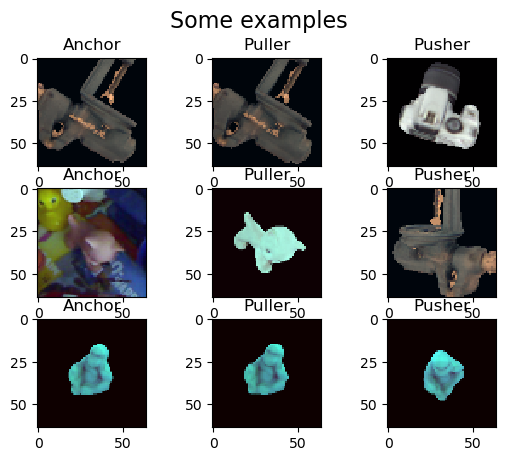

In [8]:
N = 3
imgs = islice((un_normalize(x) for x,_ in get_batch(Sdb, Strain, False)()),9)
with plt.style.context('default'):
    fig, ax = plt.subplots(N,3)
    for i in range(N):
        fig.suptitle('Some examples', fontsize=16)
        ax[i,0].set_title('Anchor')
        ax[i,0].imshow(next(imgs))
        ax[i,1].set_title('Puller')
        ax[i,1].imshow(next(imgs))
        ax[i,2].set_title('Pusher')
        ax[i,2].imshow(next(imgs))

# Task 2

Creating the neural network

### Cache

In [13]:
CACHE_DIR = 'cache/'
MODEL_PATH = os.path.join(CACHE_DIR,'cnn_model')
INPUT_PATH = os.path.join(CACHE_DIR,'cnn_input')
clean = False
if clean:
    rmtree(CACHE_DIR)
    os.makedirs(CACHE_DIR)
    
    os.makedirs(MODEL_PATH)
    os.makedirs(INPUT_PATH)

In [18]:
import math
# parameters
BATCH_SIZE = 30
EPOCHS = 200
MAX_STEPS  = int( math.ceil(len(Strain) * EPOCHS / (BATCH_SIZE/3) / 1000) ) * 1000

In [10]:
cnn_descriptor = get_model(Dataset)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cache/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a2fdebbe0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [19]:
print('Preparing model...', end='')
cnn_descriptor = get_model(Dataset)
hists = []
print('\rModel trained.')
print('Executing model')
with open('hists.csv', 'w+') as f:
    f.write('epochs,<10,<20,<40,<180\n')

tensors_to_log = [
    'triplet_loss',
    'pair_loss',
    'full_loss'
]
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=10)

input_fn = gen_train_input_fn(Sdb, Strain, BATCH_SIZE)
for x in range(1,MAX_STEPS+2, 1000):
    print('Step {}/{}'.format(x, MAX_STEPS))
    cnn_descriptor.train(
        input_fn=input_fn,
        max_steps=x
    )
    
    hist = 100 * get_hist(cnn_descriptor, Sdb, Stest) / len(Stest)
    print(hist)
    with open('hists.csv', 'a+') as f:
        arr = [str(x)] + list(map(str,hist))
        f.write(','.join(arr) + '\n')


Preparing model...INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'cache/cnn_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a3e5e05f8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Model trained.
Executing model
Step 1/50000
INFO:tensorflow:Calling model_fn.
Tensor("descriptor/Identity:0", shape=(?, 16), d

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-3001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 0.45261669  3.79066478 13.12588402 61.75388967]
Step 4001/50000
INFO:tensorflow:Calling model_fn.
Tensor("descriptor/Identity:0", shape=(?, 16), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-3001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3001 into cache/cnn_model/model.ckpt.
Shuffling dataset
INFO:tensorflow:loss = 0.96197623, step = 3002
INFO:tensorflow:global_step/sec: 10.376
INFO:tensorflow:loss = 0.69244564, step = 3102 (9.639 sec)
INFO:tensorflow:global_step/sec: 10.6883
INFO:tensorflow:loss = 0.2722752, step = 3202 

INFO:tensorflow:Loss for final step: 0.24488986.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-7001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-7001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 1.18811881  4.95049505 16.77510608 60.82036775]
Step 8001/50000
INFO:tensorflow:Calling model_fn.
Tensor("descriptor/Identity:0", shape=(?, 16), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-7001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done r

INFO:tensorflow:global_step/sec: 10.7189
INFO:tensorflow:loss = 0.24297573, step = 10702 (9.329 sec)
Shuffling dataset
INFO:tensorflow:global_step/sec: 10.6826
INFO:tensorflow:loss = 0.6088486, step = 10802 (9.361 sec)
INFO:tensorflow:global_step/sec: 10.5171
INFO:tensorflow:loss = 0.69441444, step = 10902 (9.509 sec)
INFO:tensorflow:Saving checkpoints for 11001 into cache/cnn_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.44321406.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-11001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-11001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 0.99009901  6.2

INFO:tensorflow:loss = 0.13501531, step = 14202 (9.396 sec)
INFO:tensorflow:global_step/sec: 10.6966
INFO:tensorflow:loss = 0.3778426, step = 14302 (9.349 sec)
INFO:tensorflow:global_step/sec: 10.7064
INFO:tensorflow:loss = 0.098807305, step = 14402 (9.340 sec)
INFO:tensorflow:global_step/sec: 10.6519
INFO:tensorflow:loss = 0.39346746, step = 14502 (9.388 sec)
INFO:tensorflow:global_step/sec: 10.7014
INFO:tensorflow:loss = 0.3796471, step = 14602 (9.344 sec)
INFO:tensorflow:global_step/sec: 10.712
INFO:tensorflow:loss = 0.22466838, step = 14702 (9.335 sec)
Shuffling dataset
INFO:tensorflow:global_step/sec: 10.6807
INFO:tensorflow:loss = 0.12636799, step = 14802 (9.363 sec)
INFO:tensorflow:global_step/sec: 10.6561
INFO:tensorflow:loss = 0.45750034, step = 14902 (9.385 sec)
INFO:tensorflow:Saving checkpoints for 15001 into cache/cnn_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.15158503.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:G

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-18001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 18001 into cache/cnn_model/model.ckpt.
Shuffling dataset
INFO:tensorflow:loss = 0.0935558, step = 18002
INFO:tensorflow:global_step/sec: 10.4212
INFO:tensorflow:loss = 1.0846957, step = 18102 (9.597 sec)
INFO:tensorflow:global_step/sec: 10.7322
INFO:tensorflow:loss = 2.0230393, step = 18202 (9.318 sec)
INFO:tensorflow:global_step/sec: 10.7263
INFO:tensorflow:loss = 0.10402983, step = 18302 (9.323 sec)
INFO:tensorflow:global_step/sec: 10.6943
INFO:tensorflow:loss = 0.085759364, step = 18402 (9.351 sec)
INFO:tensorflow:global_step/sec: 10.7218
INFO:tensorflow:loss = 0.31680772, step = 18502 (9.326 sec)
INFO:tensorflow:global_step/sec: 10.7443
INFO:tensorflow:loss = 0.49794728, step = 18602 (9.307 sec)
INFO:tensorflow:global_step/sec: 10.6901
INFO:tensorflow:

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-22001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 2.4893918  12.95615276 32.9844413  76.09618105]
Step 23001/50000
INFO:tensorflow:Calling model_fn.
Tensor("descriptor/Identity:0", shape=(?, 16), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-22001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 22001 into cache/cnn_model/model.ckpt.
Shuffling dataset
INFO:tensorflow:loss = 0.27946568, step = 22002
INFO:tensorflow:global_step/sec: 10.395
INFO:tensorflow:loss = 0.19233108, step = 22102 (9.621 sec)
INFO:tensorflow:global_step/sec: 10.6885
INFO:tensorflow:loss = 0.97798824, step 

INFO:tensorflow:loss = 0.08337374, step = 25802 (15.460 sec)
INFO:tensorflow:global_step/sec: 6.44206
INFO:tensorflow:loss = 0.3620158, step = 25902 (15.523 sec)
INFO:tensorflow:Saving checkpoints for 26001 into cache/cnn_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.055220537.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-26001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-26001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 4.80905233 16.01131542 38.7553041  79.8019802 ]
Step 27001/50000
INFO:tensorflow:Calling model_fn.
Tensor("descriptor/Identity:0", shape=(?, 16), dtype=float32)
INFO:tensor

INFO:tensorflow:loss = 0.069646925, step = 29302 (22.068 sec)
INFO:tensorflow:global_step/sec: 2.8877
INFO:tensorflow:loss = 0.12133278, step = 29402 (34.631 sec)
INFO:tensorflow:global_step/sec: 2.60819
INFO:tensorflow:loss = 0.973295, step = 29502 (38.341 sec)
INFO:tensorflow:global_step/sec: 2.608
INFO:tensorflow:loss = 0.07498336, step = 29602 (38.342 sec)
INFO:tensorflow:global_step/sec: 2.60934
INFO:tensorflow:loss = 0.19920549, step = 29702 (38.325 sec)
Shuffling dataset
INFO:tensorflow:global_step/sec: 2.62692
INFO:tensorflow:loss = 0.8235953, step = 29802 (38.068 sec)
INFO:tensorflow:global_step/sec: 2.9173
INFO:tensorflow:loss = 0.16999975, step = 29902 (34.276 sec)
INFO:tensorflow:Saving checkpoints for 30001 into cache/cnn_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.7803191.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-30001
INFO

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 33001 into cache/cnn_model/model.ckpt.
Shuffling dataset
INFO:tensorflow:loss = 0.104649305, step = 33002
INFO:tensorflow:global_step/sec: 4.29214
INFO:tensorflow:loss = 0.096262105, step = 33102 (23.301 sec)
INFO:tensorflow:global_step/sec: 4.51977
INFO:tensorflow:loss = 0.22580463, step = 33202 (22.124 sec)
INFO:tensorflow:global_step/sec: 5.02656
INFO:tensorflow:loss = 0.0875164, step = 33302 (19.894 sec)
INFO:tensorflow:global_step/sec: 5.14666
INFO:tensorflow:loss = 0.09004828, step = 33402 (19.430 sec)
INFO:tensorflow:global_step/sec: 5.08483
INFO:tensorflow:loss = 1.213596, step = 33502 (19.666 sec)
INFO:tensorflow:global_step/sec: 4.94096
INFO:tensorflow:loss = 0.17118603, step = 33602 (20.238 sec)
INFO:tensorflow:global_step/sec: 4.64922
INFO:tensorflow:loss = 0.15923767, step = 33702 (21.510 sec)
Shuffling dataset
INFO:tensorflow:global_step/sec: 4.0147
IN

INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-37001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 3.33804809 14.99292786 33.15417256 63.36633663]
Step 38001/50000
INFO:tensorflow:Calling model_fn.
Tensor("descriptor/Identity:0", shape=(?, 16), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-37001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 37001 into cache/cnn_model/model.ckpt.
Shuffling dataset
INFO:tensorflow:loss = 0.16839242, step = 37002
INFO:tensorflow:global_step/sec: 5.07583
INFO:tensorflow:loss = 0.09714642, step = 37102 (19.703 sec)
INFO:tensorflow:global_step/sec: 4.9793
INFO:tensorflow:loss = 0.13277687, step = 37202 (20.083 sec)
INFO:tensorflow:global_step/sec: 4.94597
INFO:tensorfl

INFO:tensorflow:Saving checkpoints for 41001 into cache/cnn_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.18467113.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-41001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-41001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[ 4.29985856 17.79349364 38.47241867 74.51202263]
Step 42001/50000
INFO:tensorflow:Calling model_fn.
Tensor("descriptor/Identity:0", shape=(?, 16), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_mo

INFO:tensorflow:loss = 0.3498203, step = 44502 (10.115 sec)
INFO:tensorflow:global_step/sec: 10.7301
INFO:tensorflow:loss = 0.03715264, step = 44602 (9.319 sec)
INFO:tensorflow:global_step/sec: 10.3411
INFO:tensorflow:loss = 0.5752511, step = 44702 (9.670 sec)
Shuffling dataset
INFO:tensorflow:global_step/sec: 10.5142
INFO:tensorflow:loss = 0.30714303, step = 44802 (9.511 sec)
INFO:tensorflow:global_step/sec: 10.6973
INFO:tensorflow:loss = 1.1922392, step = 44902 (9.348 sec)
INFO:tensorflow:Saving checkpoints for 45001 into cache/cnn_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.060957476.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-45001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

Shuffling dataset
INFO:tensorflow:loss = 0.026069656, step = 48002
INFO:tensorflow:global_step/sec: 10.2704
INFO:tensorflow:loss = 0.1427448, step = 48102 (9.738 sec)
INFO:tensorflow:global_step/sec: 9.62622
INFO:tensorflow:loss = 0.103617236, step = 48202 (10.388 sec)
INFO:tensorflow:global_step/sec: 10.5271
INFO:tensorflow:loss = 0.2099103, step = 48302 (9.499 sec)
INFO:tensorflow:global_step/sec: 9.76402
INFO:tensorflow:loss = 0.1244971, step = 48402 (10.241 sec)
INFO:tensorflow:global_step/sec: 10.4466
INFO:tensorflow:loss = 0.40910292, step = 48502 (9.573 sec)
INFO:tensorflow:global_step/sec: 9.89565
INFO:tensorflow:loss = 0.44374955, step = 48602 (10.106 sec)
INFO:tensorflow:global_step/sec: 10.0873
INFO:tensorflow:loss = 0.14254278, step = 48702 (9.913 sec)
Shuffling dataset
INFO:tensorflow:global_step/sec: 10.6464
INFO:tensorflow:loss = 0.13457964, step = 48802 (9.393 sec)
INFO:tensorflow:global_step/sec: 10.7096
INFO:tensorflow:loss = 0.047728974, step = 48902 (9.338 sec)
INFO

# Task 3

In [20]:
df = pd.read_csv('hists.csv')
df

,epochs,<10,<20,<40,<180
0,1,0.084866,0.933522,3.451202,22.828854
1,1001,0.367751,2.178218,8.288543,44.441301
2,2001,0.707214,3.507779,12.164074,49.448373
3,3001,0.452617,3.790665,13.125884,61.753890
4,4001,0.848656,5.063649,16.577086,67.553041
5,5001,0.594059,4.186704,16.520509,64.158416
6,6001,0.254597,1.584158,6.789250,42.800566
7,7001,1.188119,4.950495,16.775106,60.820368
8,8001,1.357850,6.449788,21.272984,68.656294
9,9001,1.018388,5.431400,21.782178,67.072136


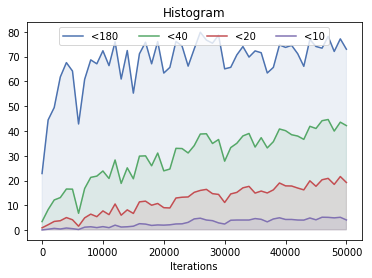

In [21]:
def plot_histograms(filename = 'hists.csv', aslog = False):
    df = pd.read_csv(filename)
    fig, ax = plt.subplots()
    
    cols = df.columns[1:]
    
    if aslog:
        df[cols] = np.log(df[cols])
    
    minimum = df[cols].min().min()
    for col in sorted(cols, key = lambda c: df[c].max(), reverse = True):
        line, = ax.plot(df.epochs, df[col], label=col)
        verts = [(df.epochs.min(), minimum), *zip(df.epochs, df[col]), (df.epochs.max(), minimum)]
        poly = Polygon(verts, color = line.get_color(), alpha = 0.1)
        ax.add_patch(poly)
        
    ax.set_title('Histogram')
    ax.set_xlabel('Steps')
    ax.legend(loc = 'upper center', ncol = 4)
    return fig, ax
fig, ax = plot_histograms(aslog = False)
fig.savefig('histograms.png', dpi=300)

In [ ]:
get_hist()

In [ ]:
def plot_confusion_matrix(model, Sdb, Stest):
    neigh = KNeighborsClassifier(n_neighbors=1)

    Sdb_descriptors, Stest_descriptors = eval_model(model, Sdb, Stest)
    X, y = Sdb_descriptors, [x.cls for x in Sdb]
    neigh.fit(X,y)

    idxs = neigh.kneighbors(Stest_descriptors)[1]

    matrix = np.zeros([N_CLASSES, N_CLASSES])
    N = len(Stest_descriptors)
    for i in range(N):
        db = Sdb[idxs[i][0]]
        test = Stest[i]
        
        cls_true = db.cls
        cls_pred = test.cls
        matrix[cls_true,cls_pred] += 1
    
    # plot here
        
    matrix = matrix/N
    print(matrix)
    
    ax = sns.heatmap(matrix, cmap = "YlGnBu")
    ax.set_xlabel('True class')
    ax.set_ylabel('Predicted class')
    return ax
plot_confusion_matrix(cnn_descriptor, Sdb, Strain)
plt.savefig('heatmap.png', dpi=300)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-50001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-50001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [16]:
def project_data(model, Stest):
    imgs, labs = zip(*[(x.img, x.cls) for x in Stest])
    imgarr = np.array(imgs)
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        imgarr,
        shuffle=False,
    )
    descs = np.array(list(model.predict(eval_input_fn)))

    metadata = os.path.join(MODEL_PATH ,'projection_metadata.tsf')
    #descriptors = tf.convert_to_tensor(descs)
    images = tf.Variable(descs, name='test_descriptors')
    print(len(descs), len(labs))
    with open(metadata, 'w+') as f:
        for cls in labs:
            f.write(str(cls) + '\n')

    with tf.Session() as sess:
        saver = tf.train.Saver([images])
        sess.run(images.initializer)
        saver.save(sess, os.path.join(MODEL_PATH ,'projection_test_descriptors.ckpt'))
project_data(cnn_descriptor,Stest)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from cache/cnn_model/model.ckpt-50001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
3535 3535
